# Stock Price Prediction with LSTM Tensorflow

## In This we are going to build a LSTM (Long Short Term Memory neural network it is a kind of RNN's ) capable of learning from past so as this stock market is timeseries problem so we will be using this for better understanding about this visit
http://colah.github.io/posts/2015-08-Understanding-LSTMs/
and this project was made with the help of this post
https://medium.com/@dmytrosazonov/how-to-predict-stock-market-using-google-tensorflow-and-lstm-neural-network-81ccc41a22a8

What do we need here:
1. Load data
2. Scale data for machine learning model
3. Setup neural network
4. Compile model
5. Teach neural netowk and fit this
6. Use the model for prediction
7. Draw the results chart

In [ ]:
# Requirements
!pip install yahoo_fin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 4.9 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=b0f366d377fe972cbc2c1717272f1caee9b54f84a4302940843d3b9880eb4c97
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


In [ ]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# neural networks
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

# SETTINGS

In [ ]:

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker
STOCK = 'GOOGL'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [ ]:
init_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

In [ ]:
init_df

,open,high,low,close,adjclose,volume,ticker
2021-07-15,128.649002,128.699997,126.529999,127.004997,126.859406,24218000,GOOGL
2021-07-16,127.663002,127.811501,126.153503,126.970001,126.824448,20424000,GOOGL
2021-07-19,126.089500,126.205002,123.504997,124.578003,124.435188,27968000,GOOGL
2021-07-20,125.527496,127.042999,124.350502,126.209503,126.064819,26312000,GOOGL
2021-07-21,126.133499,127.596001,126.023499,127.549004,127.402786,20746000,GOOGL
...,...,...,...,...,...,...,...
2024-07-16,187.360001,188.679993,183.369995,183.919998,183.919998,18290700,GOOGL
2024-07-17,182.970001,183.550003,179.899994,181.020004,181.020004,20734100,GOOGL
2024-07-18,181.929993,182.500000,176.470001,177.690002,177.690002,25315700,GOOGL
2024-07-19,178.880005,180.289993,177.130005,177.660004,177.660004,18881900,GOOGL


In [ ]:
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

In [ ]:
init_df

,close,date
2021-07-15,127.004997,2021-07-15
2021-07-16,126.970001,2021-07-16
2021-07-19,124.578003,2021-07-19
2021-07-20,126.209503,2021-07-20
2021-07-21,127.549004,2021-07-21
...,...,...
2024-07-16,183.919998,2024-07-16
2024-07-17,181.020004,2024-07-17
2024-07-18,177.690002,2024-07-18
2024-07-19,177.660004,2024-07-19


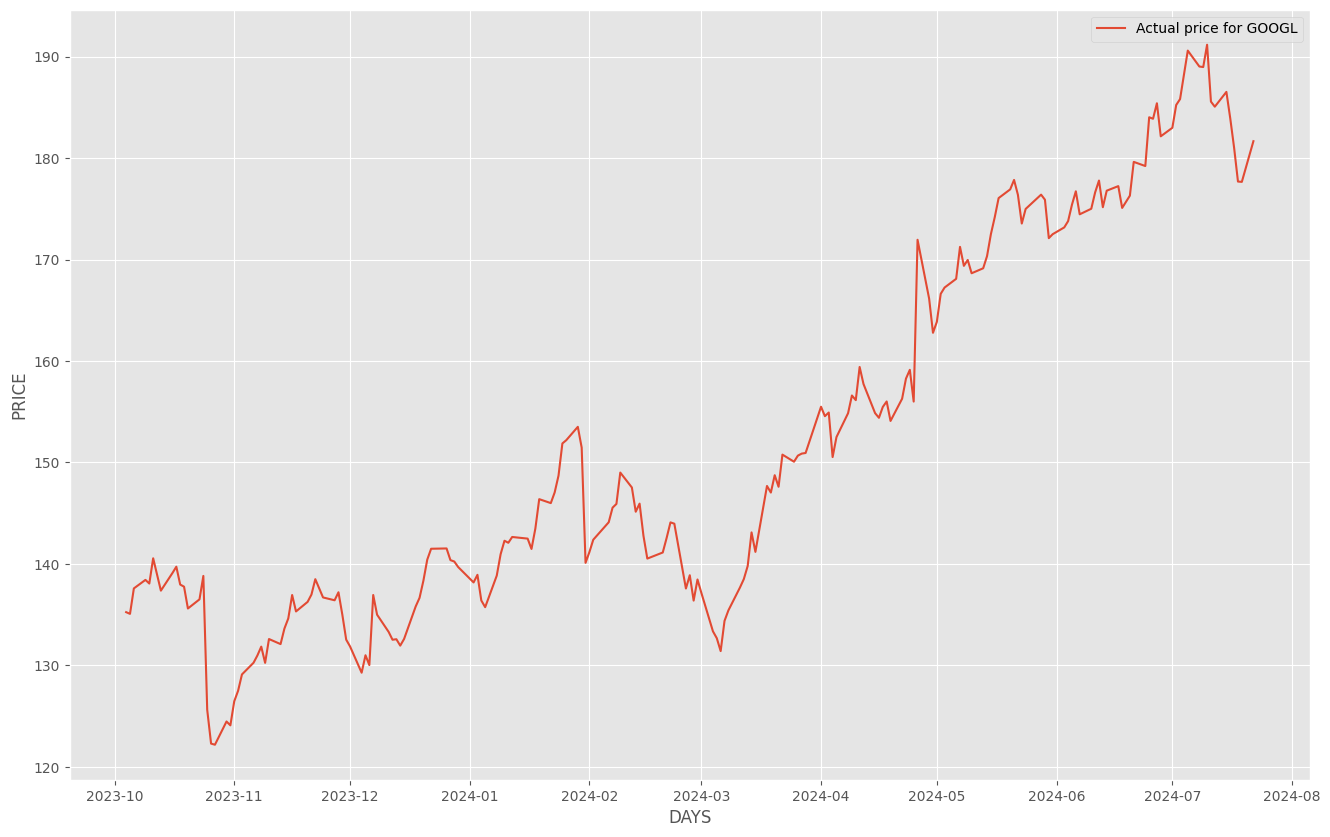

In [ ]:
plt.style.use(style="ggplot")
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])# plots last 200 days graph
plt.xlabel("DAYS")
plt.ylabel("PRICE")
plt.legend([f"Actual price for {STOCK}"])
plt.show()

In [ ]:
scaler = MinMaxScaler()
init_df["scaled_close"] = scaler.fit_transform(np.expand_dims(init_df["close"].values,axis=1))

In [ ]:
init_df["close"][:5],init_df["close"].shape

(2021-07-15    127.004997
 2021-07-16    126.970001
 2021-07-19    124.578003
 2021-07-20    126.209503
 2021-07-21    127.549004
 Name: close, dtype: float64,
 (759,))

In [ ]:
np.expand_dims(init_df['close'].values, axis=1)[:5]

array([[127.00499725],
       [126.97000122],
       [124.57800293],
       [126.20950317],
       [127.5490036 ]])

In [ ]:
init_df

,close,date,scaled_close
2021-07-15,127.004997,2021-07-15,0.404408
2021-07-16,126.970001,2021-07-16,0.404084
2021-07-19,124.578003,2021-07-19,0.381884
2021-07-20,126.209503,2021-07-20,0.397026
2021-07-21,127.549004,2021-07-21,0.409457
...,...,...,...
2024-07-16,183.919998,2024-07-16,0.932622
2024-07-17,181.020004,2024-07-17,0.905708
2024-07-18,177.690002,2024-07-18,0.874803
2024-07-19,177.660004,2024-07-19,0.874524


In [ ]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [ ]:
PrepareData(3)

(                 close       date  scaled_close    future
 2021-07-15  127.004997 2021-07-15      0.404408  0.397026
 2021-07-16  126.970001 2021-07-16      0.404084  0.409457
 2021-07-19  124.578003 2021-07-19      0.381884  0.417554
 2021-07-20  126.209503 2021-07-20      0.397026  0.460186
 2021-07-21  127.549004 2021-07-21      0.409457  0.469652
 ...                ...        ...           ...       ...
 2024-07-11  185.570007 2024-07-11      0.947935  0.932622
 2024-07-12  185.070007 2024-07-12      0.943295  0.905708
 2024-07-15  186.529999 2024-07-15      0.956845  0.874803
 2024-07-16  183.919998 2024-07-16      0.932622  0.874524
 2024-07-17  181.020004 2024-07-17      0.905708  0.911740
 
 [756 rows x 4 columns],
 array([[0.97958237],
        [1.        ],
        [0.94793516],
        [0.9432948 ],
        [0.9568446 ],
        [0.93262184],
        [0.9057078 ],
        [0.8748029 ],
        [0.8745245 ],
        [0.9117402 ]], dtype=float32),
 array([[[0.4044083529803532

In [ ]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 1
  EPOCHS = 1

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model


In [ ]:
#model.save("stock_model.h5")

In [ ]:
#x_train[len(x_t):]

NameError: name 'x_train' is not defined

In [ ]:
import time
start_time = time.time()
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(tf.constant(x_train), tf.constant(y_train))
  #model = tf.keras.models.load_model("stock_model.h5")
  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(tf.constant(last_sequence))
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))
print("--- %s seconds ---" % round((time.time() - start_time),2))
len(x_train)

752/752 [==============================] - 14s 7ms/step - loss: 0.0074
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 60)             14880     
                                                                 
 dropout (Dropout)           (None, 7, 60)             0         
                                                                 
 lstm_1 (LSTM)               (None, 120)               86880     
                                                                 
 dropout_1 (Dropout)         (None, 120)               0         
                                                                 
 dense (Dense)               (None, 20)                2420      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                   

750

In [ ]:
#model.save('stock_model.h5')

In [ ]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'
  print(message)

GOOGL prediction for upcoming 3 days (178.09$, 162.66$, 182.81$)


In [ ]:
import pandas as pd
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed
copy_df.tail(5)

24/24 [==============================] - 0s 3ms/step


,close,date,scaled_close,predicted_close
2024-07-16,183.919998,2024-07-16,0.932622,188.149445
2024-07-17,181.020004,2024-07-17,0.905708,187.114944
2024-07-18,177.690002,2024-07-18,0.874803,177.690002
2024-07-19,177.660004,2024-07-19,0.874524,177.660004
2024-07-22,181.669998,2024-07-22,0.911740,181.669998


In [ ]:
import pandas as pd
pd.Series(y_predicted_transformed).shape
y_predicted_transformed.shape

(759,)

In [ ]:
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)
copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

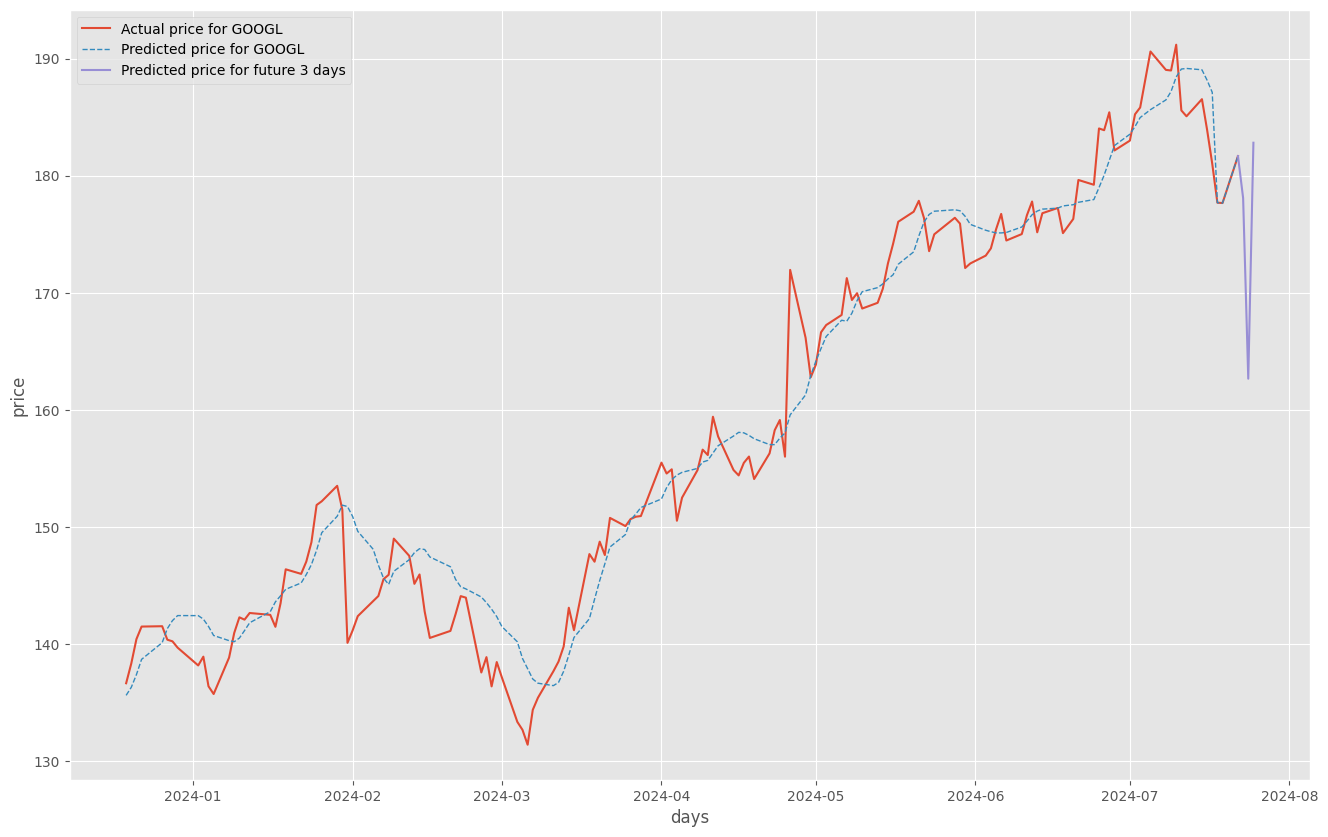

In [ ]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()